In [50]:
import pickle

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from pt_runner.cnn import CheckpointHandler, DataHandlerPT, EarlyStopper, calc_metrices


In [51]:
# New run
# NEW_RUN = True
# DT_REF = None

# Resuming
NEW_RUN = False
DT_REF = "2025-05-28_12-35"


In [52]:
RANDOM_STATE = 0

In [53]:
with open("mnist_small.pickle", "rb") as file:
    data = pickle.load(file)

In [54]:
_X = data["_X"].astype(np.float64)
_Y = data["_Y"].astype(np.int32)
print(_X.shape)
print(_X.dtype)
print(_Y.shape)
print(_Y.dtype)

(2000, 1, 28, 28)
float64
(2000, 1)
int32


In [55]:
data_handler = DataHandlerPT(_X=_X, _Y=_Y)

In [ ]:
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: input channels=3 (e.g., RGB), output channels=16, kernel size=3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        # Fully connected layer
        self.fc1 = nn.Linear(
            32 * 4 * 4, num_classes
        )  # Adjust input size depending on image size!

    def forward(self, X):
        # 1st Conv + Activation + Pooling
        X = self.conv1(X)
        X = self.relu(X)
        X = self.max_pool(X)
        # 2nd Conv + Activation + Pooling
        X = self.conv2(X)
        X = self.relu(X)
        X = self.max_pool(X)

        X = self.adaptive_pool(X)
        # Flatten the output for the fully connected layer
        X = X.view(X.shape[0], -1)
        # Fully connected output
        X = self.fc1(X)
        return X


model = SimpleCNN(num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5)
loss_fn = nn.CrossEntropyLoss()


# Test
X = torch.randn(10, 1, 28, 28)
model(X)

tensor([[-0.2563,  0.1478,  0.1046, -0.0830,  0.2386,  0.0482,  0.1006,  0.3657,
         -0.0696,  0.3571],
        [-0.2779,  0.0813,  0.1661, -0.0889,  0.2888,  0.0782,  0.0639,  0.3085,
         -0.0748,  0.2956],
        [-0.2601,  0.1471,  0.0978, -0.0854,  0.3014,  0.0440,  0.1327,  0.3819,
         -0.0331,  0.3109],
        [-0.2770,  0.2028,  0.1734, -0.0665,  0.2729,  0.0648,  0.0765,  0.2786,
         -0.0208,  0.3000],
        [-0.2136,  0.0972,  0.0965, -0.0632,  0.2989,  0.0419,  0.0892,  0.3188,
         -0.0397,  0.3321],
        [-0.2689,  0.1032,  0.0961, -0.1173,  0.2684,  0.0407,  0.0717,  0.4053,
         -0.0537,  0.2938],
        [-0.2286,  0.0772,  0.0764, -0.1276,  0.3028,  0.0352,  0.1064,  0.3786,
          0.0191,  0.3089],
        [-0.2574,  0.1200,  0.1219, -0.1274,  0.3003,  0.0593,  0.1146,  0.3990,
         -0.1053,  0.2600],
        [-0.2431,  0.0836,  0.0804, -0.0925,  0.2770,  0.0357,  0.1126,  0.3945,
         -0.0383,  0.3458],
        [-0.3521,  

In [ ]:
from torchinfo import summary

input_size = (100, 1, 32, 32)  # (batch_size, channels, height, width)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [100, 10]                 --
├─Conv2d: 1-1                            [100, 16, 32, 32]         160
├─ReLU: 1-2                              [100, 16, 32, 32]         --
├─MaxPool2d: 1-3                         [100, 16, 16, 16]         --
├─Conv2d: 1-4                            [100, 32, 16, 16]         4,640
├─ReLU: 1-5                              [100, 32, 16, 16]         --
├─MaxPool2d: 1-6                         [100, 32, 8, 8]           --
├─AdaptiveAvgPool2d: 1-7                 [100, 32, 4, 4]           --
├─Linear: 1-8                            [100, 10]                 5,130
Total params: 9,930
Trainable params: 9,930
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 135.68
Input size (MB): 0.41
Forward/backward pass size (MB): 19.67
Params size (MB): 0.04
Estimated Total Size (MB): 20.12

`tensorboard --logdir=src/T03_cnn/runs`

In [ ]:
n_epochs = 1000  # number of epochs to run
batch_size = 10  # size of each batch
validation_interval = 10  # Evaluate every 100 epochs
log_name = "C1"

# Save/load
cph = CheckpointHandler()
cph.make_dir("./checkpoints")
if NEW_RUN:
    dt = cph.get_dt()
    log_dir = f"runs/{dt}"
    save_path = f"./checkpoints/{dt}.pth"
    epoch_start = 0
else:
    log_dir = f"runs/{DT_REF}"
    load_path = f"./checkpoints/{DT_REF}.pth"
    save_path = load_path
    model, optimizer, epoch, val_loss = cph.load(
        load_path=load_path, model=model, optimizer=optimizer
    )
    epoch_start = epoch
    print(f"Resuming from epoch: {epoch_start}")

epoch_end = epoch_start + n_epochs

# Initialize Components
early_stopper = EarlyStopper(patience=10)
writer = SummaryWriter(log_dir=log_dir, purge_step=epoch_start)

# Data
data_handler.split_and_scale(test_size=0.2, val_size=0.1, random_state=RANDOM_STATE)
ds_train = data_handler.get_train()
ds_test = data_handler.get_test()
ds_val = data_handler.get_val()
loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

# Main loop
for epoch in tqdm(
    range(epoch_start, epoch_end), initial=epoch_start, desc="Epoch", total=n_epochs
):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_f1 = 0.0
    logit_arr = []
    label_arr = []

    for X_batch, Y_batch in loader_train:
        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = loss_fn(Y_pred, Y_batch.view(-1))
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        # Update weights
        optimizer.step()
        # Multiplies the average loss per sample by the number of
        # samples in the batch to get the total loss for this batch.
        epoch_train_loss += loss.item() * X_batch.size(0)
        logit_arr.append(Y_pred)
        label_arr.append(Y_batch)

    avg_train_loss = epoch_train_loss / len(loader_train.dataset)

    logits = torch.concat(logit_arr, dim=0)
    labels = torch.concat(label_arr, dim=0)
    metrices, _, _ = calc_metrices(logits=logits, labels=labels.view(-1))
    avg_train_f1 = metrices["weighted avg"]["f1-score"]

    # Validation Phase
    if epoch % validation_interval == 0 or epoch == epoch_start:
        model.eval()
        val_loss = 0.0
        logit_arr = []
        label_arr = []
        with torch.no_grad():
            for X_val, Y_val in loader_val:
                Y_pred = model(X_val)
                val_loss += loss_fn(Y_pred, Y_val.view(-1)).item() * X_val.size(0)
                logit_arr.append(Y_pred)
                label_arr.append(Y_val)

        avg_val_loss = val_loss / len(loader_val.dataset)

        logits = torch.concat(logit_arr, dim=0)
        labels = torch.concat(label_arr, dim=0)
        metrices, _, _ = calc_metrices(logits=logits, labels=labels.view(-1))
        avg_val_f1 = metrices["weighted avg"]["f1-score"]

        scheduler.step(avg_val_loss)

        # Early Stopping and Checkpoint
        es = early_stopper(avg_val_loss)
        if es["best_loss"]:
            cph.save(
                save_path=save_path,
                model=model,
                optimizer=optimizer,
                val_loss=avg_val_loss,
                epoch=epoch,
            )
            print("Save model @ epoch:", epoch)
        if es["early_stop"]:
            print("Stopped at epoch:", epoch)
            break

    writer.add_scalars(
        log_name, {"loss/train": avg_train_loss, "loss/val": avg_val_loss}, epoch
    )
    writer.add_scalars(
        log_name, {"f1/train": avg_train_f1, "f1/val": avg_val_f1}, epoch
    )


Resuming from epoch: 170


Epoch:  17%|#7        | 170/1000 [00:00<?, ?it/s]

Save model @ epoch: 170
Save model @ epoch: 180
Save model @ epoch: 190
Save model @ epoch: 200
Stopped at epoch: 300


In [69]:
model.eval()
with torch.no_grad():
    X_test, Y_test = ds_test[:]
    test_pred = model(X_test)
    final_loss = loss_fn(test_pred, Y_test.view(-1))
    print(f"Test loss: {final_loss:.4f}")

Test loss: 0.1700


In [70]:
metrices, Y_pred_labels, Y_true_labels = calc_metrices(
    logits=test_pred, labels=Y_test.view(-1), isPrint=True
)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        40
           1      0.977     1.000     0.989        43
           2      0.977     0.977     0.977        43
           3      0.978     0.898     0.936        49
           4      1.000     1.000     1.000        33
           5      0.935     0.967     0.951        30
           6      1.000     0.981     0.990        52
           7      0.956     1.000     0.977        43
           8      0.971     1.000     0.986        34
           9      0.970     0.970     0.970        33

    accuracy                          0.978       400
   macro avg      0.976     0.979     0.978       400
weighted avg      0.978     0.978     0.977       400



In [71]:
# Find misclassification
loc = Y_pred_labels != Y_true_labels
print(f"Missclassification = {loc.sum()}")

Missclassification = 9


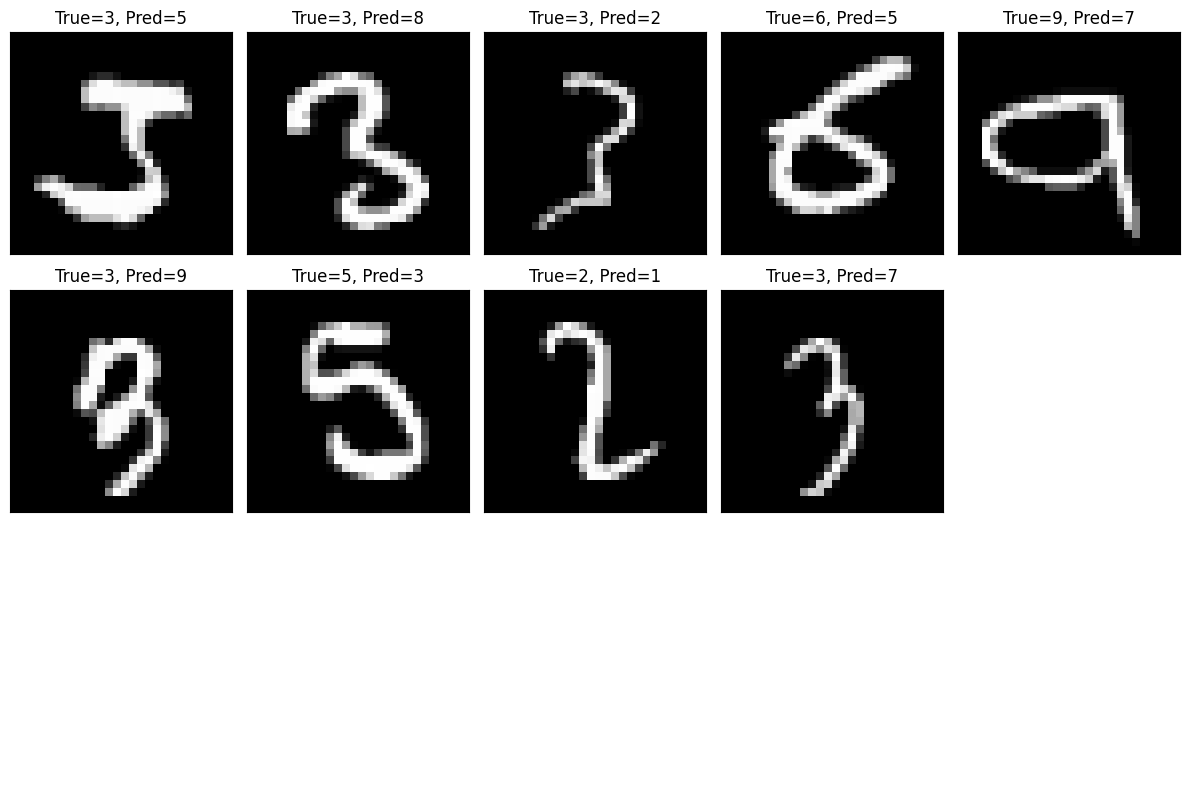

In [87]:
import matplotlib.pyplot as plt
import itertools

fig, axes2D = plt.subplots(3, 5, figsize=(12, 8))
axes = list(itertools.chain.from_iterable(axes2D))  # Flatten 2D list
X_test_miss, _ = ds_test[loc]
Y_test_miss = Y_true_labels[loc]
Y_pred_miss = Y_pred_labels[loc]
for idx, ax in enumerate(axes):
    if (idx < loc.sum()):
        ax.imshow(X_test_miss[idx].view(28, 28), cmap="gray")
        ax.set_title(f"True={Y_test_miss[idx]}, Pred={Y_pred_miss[idx]}")
    else:
        ax.axis('off')  # Hide unused axes
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()